In [45]:
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import tqdm
from tqdm import tqdm
import cv2
import dlib
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label  
import imgaug as ia
import glob


#Used for Run-Length-Encoding RLE to create final submission
%matplotlib inline

<b>Get datasets</b>

In [17]:
project_files_path = "/home/catherine/Documents/Data/fear_project"

def get_files(cat, source_path):
    """
    args:
        cat - (str) category/class 
        e.g 'pain', 'neutral', 'fear'
        enter in lowercase
        
    """
    training_files = glob.glob(source_path + "/train/%s/*" %cat)
    val_files = glob.glob(source_path + "/val/%s/*" %cat)
    test_files = glob.glob(source_path + "/test/%s/*" %cat)
    
    return training_files, val_files, test_files

In [18]:
#Neutral
training_files_N, val_files_N, test_files_N = get_files('neutral', project_files_path) 

training_files_F, val_files_F, test_files_F = get_files('fear', project_files_path) 

print("====Neutral====\n")
print("Number of training:", len(training_files_N))
print("Number of validation:", len(val_files_N))
print("Number of test:", len(test_files_N))

print("====Fear====\n")
print("Number of training:", len(training_files_F))
print("Number of validation:", len(val_files_F))
print("Number of test:", len(test_files_F))

====Neutral====

Number of training: 4000
Number of validation: 2000
Number of test: 378
====Fear====

Number of training: 4000
Number of validation: 2000
Number of test: 378


In [19]:
test_files_F[:10]

['/home/catherine/Documents/Data/fear_project/test/fear/267c7eaebef615a85f5261d33da46f6ae1d9641261f89efe7cae8f8e.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/c895158bee18886c7c1f88eb44f9ba2cd14b92c1e6b88bac62825d43.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/6da0cb1a9872984f14fb647416d545f0c0741c2202ec8381c82acfa6.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/d279cadfbda2bee025bd5c55394f32f2995ff85ddb3e132e59ac3ea6.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/2030d7358b78edbfbccea3f596f1e46767698deab066cb9d54c3dcc3.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/4994be17e5646e4d1103e76973e8f7e69be30ecd316df2f55b15d2e2.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/b3bc69af7d6ee8b8b77b3a619cb5fd508a148d6bd477ff69a958ac3f.png',
 '/home/catherine/Documents/Data/fear_project/test/fear/cca149a4f3d1c99caae055213c8d4e296bed4f04ba1b0a1c09a5f86c.png',
 '/home/catherine/Documents/Data/fear_project/te

<b>Detect faces</b>

In [20]:
haar_face = "haarcascade_frontalface_alt.xml"

faceCascade = cv2.CascadeClassifier(haar_face)

detector = dlib.get_frontal_face_detector() #detects faces


def extractfaces(directory_data, cat, im_size): 
    """
    args:
        cat - (str) category/class 
        e.g 'pain', 'neutral', 'fear'
        enter with quotes like 'pain'
        
        imsize - (int)square, image dimensions for width and height
        e.g. 100 => resizes to 100 x 100 image
        
    returns: 
        dataset and labels
        labels is the string cat 
    """
    im_size = im_size
    dataset = []
    labels = []
    #Append data to training and test list, and generate labels 0-1
    for item in directory_data:
        image = cv2.imread(item, flags=cv2.IMREAD_COLOR) #open image
        face = ia.imresize_single_image(image, (im_size, im_size)) #resize
        gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        detected_faces = faceCascade.detectMultiScale(rgb, scaleFactor=1.1, minNeighbors=3, minSize=(20, 20), flags=cv2.CASCADE_SCALE_IMAGE) #detect faces
        for face in detected_faces:
            (X, Y, w, h) = face
            if w > 20:
                # extract the face
                horizontal_offset = 0
                vertical_offset = 0
                extracted_face = rgb[Y+vertical_offset:Y+h, X+horizontal_offset:X-horizontal_offset+w]
                extracted_face_r = ia.imresize_single_image(extracted_face, (im_size, im_size)) #resize
            dataset.append(extracted_face_r) #append image array to training data list
            labels.append(cat)
    return dataset, labels





With 'RGB' and no grayscale

In [21]:
#Neutral set 
N_rgb_train, N_rgb_train_labels = extractfaces(training_files_N, 'neutral', im_size = 100)
N_rgb_val, N_rgb_val_labels = extractfaces(val_files_N, 'neutral', im_size = 100)
N_rgb_test, N_rgb_test_labels = extractfaces(test_files_N, 'neutral', im_size = 100)

In [22]:
#Fear set
F_rgb_train, F_rgb_train_labels = extractfaces(training_files_F, 'fear', im_size = 100)
F_rgb_val, F_rgb_val_labels = extractfaces(val_files_F, 'fear', im_size = 100)
F_rgb_test, F_rgb_test_labels = extractfaces(test_files_F, 'fear', im_size = 100)

In [23]:
#view examples
F_rgb_train[:3]

[array([[[ 62,  62,  62],
         [ 65,  65,  65],
         [ 72,  72,  72],
         ...,
         [122, 122, 122],
         [127, 127, 127],
         [137, 137, 137]],
 
        [[ 70,  70,  70],
         [ 72,  72,  72],
         [ 72,  72,  72],
         ...,
         [128, 128, 128],
         [135, 135, 135],
         [145, 145, 145]],
 
        [[ 75,  75,  75],
         [ 79,  79,  79],
         [ 74,  74,  74],
         ...,
         [129, 129, 129],
         [135, 135, 135],
         [146, 146, 146]],
 
        ...,
 
        [[ 80,  80,  80],
         [ 74,  74,  74],
         [ 75,  75,  75],
         ...,
         [ 33,  33,  33],
         [ 36,  36,  36],
         [ 38,  38,  38]],
 
        [[ 91,  91,  91],
         [ 85,  85,  85],
         [ 85,  85,  85],
         ...,
         [ 33,  33,  33],
         [ 36,  36,  36],
         [ 36,  36,  36]],
 
        [[112, 112, 112],
         [102, 102, 102],
         [ 99,  99,  99],
         ...,
         [ 32,  32,  32],
  

In [24]:
print("=====Neutral Train=====\n")
print('Original images:', len(training_files_N))
print('Extracted faces:', len(N_rgb_train))

print("=====Fear Train=====\n")
print('Original images:', len(training_files_F))
print('Extracted faces:', len(F_rgb_train))



=====Neutral Train=====

Original images: 4000
Extracted faces: 3884
=====Fear Train=====

Original images: 4000
Extracted faces: 3834


In [25]:
#SHAPE OF ALL IMAGES
N_rgb_train[0].shape

(100, 100, 3)

NameError: name 'N_rgb_train' is not defined

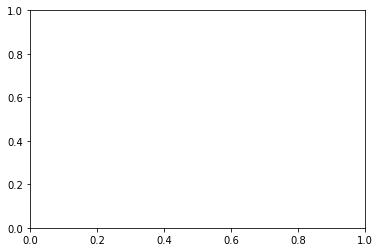

In [20]:
from matplotlib.pyplot import *

ax = matplotlib.pyplot.gca()
print(ax.imshow(N_rgb_train[0], cmap='gray'))

In [27]:
len(F_rgb_train)

3834

AxesImage(54,36;334.8x217.44)


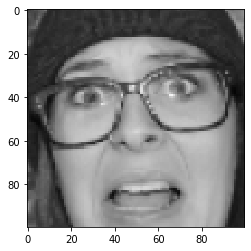

AxesImage(54,36;334.8x217.44)


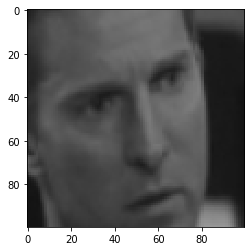

AxesImage(54,36;334.8x217.44)


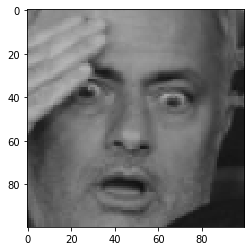

AxesImage(54,36;334.8x217.44)


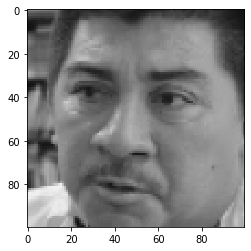

AxesImage(54,36;334.8x217.44)


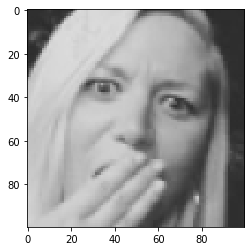

AxesImage(54,36;334.8x217.44)


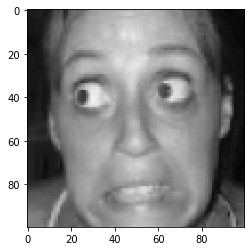

AxesImage(54,36;334.8x217.44)


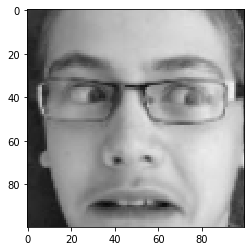

AxesImage(54,36;334.8x217.44)


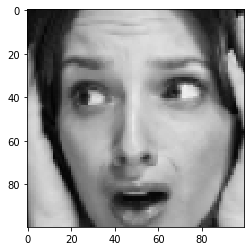

AxesImage(54,36;334.8x217.44)


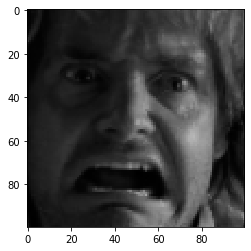

AxesImage(54,36;334.8x217.44)


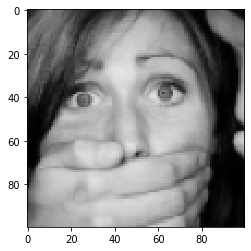

AxesImage(54,36;334.8x217.44)


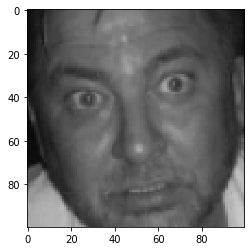

AxesImage(54,36;334.8x217.44)


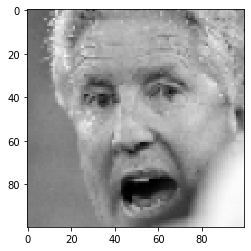

AxesImage(54,36;334.8x217.44)


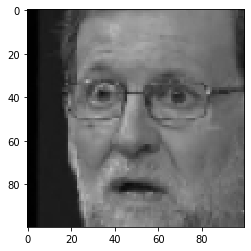

AxesImage(54,36;334.8x217.44)


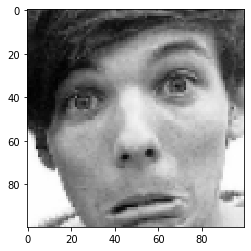

AxesImage(54,36;334.8x217.44)


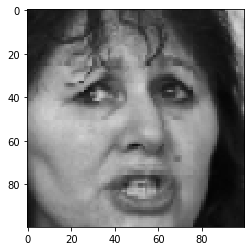

AxesImage(54,36;334.8x217.44)


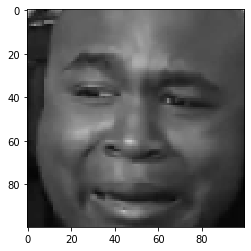

AxesImage(54,36;334.8x217.44)


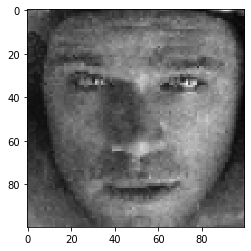

AxesImage(54,36;334.8x217.44)


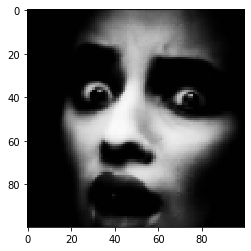

AxesImage(54,36;334.8x217.44)


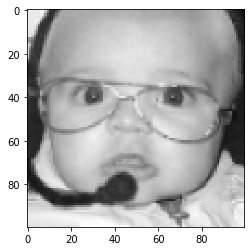

AxesImage(54,36;334.8x217.44)


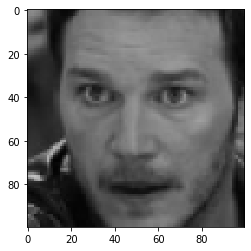

In [28]:
for i in range(0, 20):
    ax = matplotlib.pyplot.gca()
    print(ax.imshow(F_rgb_train[i]))
    matplotlib.pyplot.show()

<b>Convert all to arrays</b>

In [29]:
#images to arrays
N_rgb_train_arr = np.array(N_rgb_train)
N_rgb_val_arr = np.array(N_rgb_val)
N_rgb_test_arr = np.array(N_rgb_test) 

F_rgb_train_arr = np.array(F_rgb_train) 
F_rgb_val_arr = np.array(F_rgb_val)
F_rgb_test_arr = np.array(F_rgb_test)

print("=====NEUTRAL=====\n")
print(N_rgb_train_arr.shape)
print(N_rgb_val_arr.shape)
print(N_rgb_test_arr.shape)

print("======FEAR======\n")
print(F_rgb_train_arr.shape)
print(F_rgb_val_arr.shape)
print(F_rgb_test_arr.shape)


=====NEUTRAL=====

(3884, 100, 100, 3)
(1942, 100, 100, 3)
(373, 100, 100, 3)
======FEAR======

(3834, 100, 100, 3)
(1907, 100, 100, 3)
(362, 100, 100, 3)


In [30]:
#labels to arrays

#Neutral
N_rgb_trainlabs_arr = np.array(N_rgb_train_labels)
N_rgb_vallabs_arr = np.array(N_rgb_val_labels)
N_rgb_testlabs_arr = np.array(N_rgb_test_labels)

#Fear
F_rgb_trainlabs_arr = np.array(F_rgb_train_labels)
F_rgb_vallabs_arr = np.array(F_rgb_val_labels)
F_rgb_testlabs_arr = np.array(F_rgb_test_labels)

print("=====NEUTRAL=====\n")
print(N_rgb_trainlabs_arr.shape)
print(N_rgb_vallabs_arr.shape)
print(N_rgb_testlabs_arr.shape)

print("======FEAR======\n")
print(F_rgb_trainlabs_arr.shape)
print(F_rgb_vallabs_arr.shape)
print(F_rgb_testlabs_arr.shape)


=====NEUTRAL=====

(3884,)
(1942,)
(373,)
======FEAR======

(3834,)
(1907,)
(362,)


<b>Concatenate images and labels</b>

In [31]:
#====Training Set========
#Master Training Images
#concatenate to make master training rgb data set
train_images = np.concatenate((N_rgb_train_arr, F_rgb_train_arr), axis=0)
#Master Training Labels
train_labels = np.concatenate((N_rgb_trainlabs_arr, F_rgb_trainlabs_arr), axis=0)

#====Validation Set======
#Master Val Images
val_images = np.concatenate((N_rgb_val_arr, F_rgb_val_arr), axis=0)
#Master Val Labels
val_labels = np.concatenate((N_rgb_vallabs_arr, F_rgb_vallabs_arr), axis=0)

#=====Test Set===========
#Master Test Images
test_images = np.concatenate((N_rgb_test_arr, F_rgb_test_arr), axis=0)
#Master Test Labels
test_labels = np.concatenate((N_rgb_testlabs_arr, F_rgb_testlabs_arr), axis=0)

print("=====TRAINING SET=====\n")
print("Training set shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("=====VALIDATION SET=====\n")
print("Val set shape:", val_images.shape)
print("Val labels shape:", val_labels.shape)
print("=====TEST SET=====\n")
print("Test set shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)




=====TRAINING SET=====

Training set shape: (7718, 100, 100, 3)
Training labels shape: (7718,)
=====VALIDATION SET=====

Val set shape: (3849, 100, 100, 3)
Val labels shape: (3849,)
=====TEST SET=====

Test set shape: (735, 100, 100, 3)
Test labels shape: (735,)


AxesImage(54,36;334.8x217.44)
Labels: fear


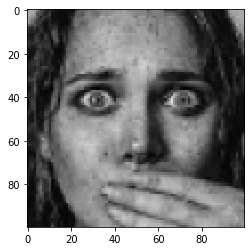

In [32]:
num = 6000

ax = matplotlib.pyplot.gca()
print(ax.imshow(train_images[num], cmap='gray'))
print("Labels:", train_labels[num])

<b>Encode into categoricals, labels</b>

In [33]:
from sklearn import preprocessing

train_labels = train_labels.reshape(-1, 1)
val_labels = val_labels.reshape(-1, 1)
test_labels= test_labels.reshape(-1, 1)

lb = preprocessing.LabelBinarizer()

lb_trainlabels = lb.fit_transform(train_labels)
lb_vallabels = lb.fit_transform(val_labels)
lb_testlabels = lb.fit_transform(test_labels)

In [34]:
#check 
print(train_labels[:10])
print(lb_trainlabels[:10])

[['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']
 ['neutral']]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [35]:
#for PyTorch
y_train = lb_trainlabels.reshape(-1)
y_val = lb_vallabels.reshape(-1)
y_test = lb_testlabels.reshape(-1)

In [36]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

PyTorch will shuffle the set when I use DataLoader.

<b>Normalize Images</b>

In [37]:
#normalize
x_train = np.array(train_images, np.float32) / 255. #really only the x set is getting normalized
x_val = np.array(val_images, np.float32) / 255
x_test = np.array(test_images, np.float32) / 255. #really only the x set is getting normalized


In [38]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(7718, 100, 100, 3)
(3849, 100, 100, 3)
(735, 100, 100, 3)
(7718,)
(3849,)
(735,)


In [39]:
x_train.shape

(7718, 100, 100, 3)

In [ ]:
#skip all below, if loading 
os.chdir("/home/catherine/Documents/Scripts/final_scripts_and_models")
np.save("x_train_pytorch.npy", x_train)
np.save("x_val_pytorch.npy", x_val)
np.save("x_test_pytorch.npy", x_test)

np.save("y_train_pytorch.npy", y_train)
np.save("y_val_pytorch.npy", y_val)
np.save("y_test_pytorch.npy", y_test)

In [3]:
os.chdir("/home/catherine/Documents/Scripts/final_scripts_and_models")
x_train = np.load("x_train_pytorch.npy")
x_val = np.load("x_val_pytorch.npy")
x_test = np.load("x_test_pytorch.npy")

y_train = np.load("y_train_pytorch.npy")
y_val = np.load("y_val_pytorch.npy")
y_test = np.load("y_test_pytorch.npy")

In [4]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(7718, 100, 100, 3)
(3849, 100, 100, 3)
(735, 100, 100, 3)
(7718,)
(3849,)
(735,)


<h1>PyTorch</h1>

In [5]:
train_x = x_train.reshape(7718, 3, 100, 100)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(y_train.astype(int))

In [6]:
val_x = x_val.reshape(3849, 3, 100, 100)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(y_val.astype(int))

In [7]:
test_x = x_test.reshape(735, 3, 100, 100)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(y_test.astype(int))

In [8]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

(torch.Size([7718, 3, 100, 100]),
 torch.Size([7718]),
 torch.Size([3849, 3, 100, 100]),
 torch.Size([3849]),
 torch.Size([735, 3, 100, 100]),
 torch.Size([735]))

<b>Model</b>

In [21]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [98]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.AvgPool2d(2, 2) #fear3 model was Max; now fear4 model is AvgPool
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(128 * 12 * 12, 1000)
        
        self.fc2 = nn.Linear(1000, 84)
        
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [23]:
#fear 5 - don't pool until after second conv

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2) #was Max
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(128, 184, kernel_size=2, stride=1, padding=0)
        
        self.fc1 = nn.Linear(184 * 24 * 24, 1000)
        
        self.fc2 = nn.Linear(1000, 50)
        
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 184 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 184, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=105984, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [24]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
train_x, train_y = train_x.to(device), train_y.to(device)
val_x, val_y = val_x.to(device), val_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x, train_y)
val = torch.utils.data.TensorDataset(val_x, val_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = 8, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 8, shuffle = True)
    

In [ ]:
total_step = len(train_loader)
loss_list = []
acc_list = []
num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = net(images)
        loss = criterion(outputs,labels)
        print("---", loss, "---")
        
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



In [179]:
#maybe try this

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 400 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 400))
            running_loss = 0.0

print('Finished Training')

[1,   400] loss: 0.587
[1,   800] loss: 0.590
[2,   400] loss: 0.578
[2,   800] loss: 0.578
[3,   400] loss: 0.556
[3,   800] loss: 0.576
[4,   400] loss: 0.557
[4,   800] loss: 0.550
[5,   400] loss: 0.525
[5,   800] loss: 0.535
[6,   400] loss: 0.510
[6,   800] loss: 0.522
[7,   400] loss: 0.492
[7,   800] loss: 0.497
[8,   400] loss: 0.461
[8,   800] loss: 0.476
[9,   400] loss: 0.420
[9,   800] loss: 0.443
[10,   400] loss: 0.392
[10,   800] loss: 0.392
[11,   400] loss: 0.327
[11,   800] loss: 0.362
[12,   400] loss: 0.286
[12,   800] loss: 0.303
[13,   400] loss: 0.234
[13,   800] loss: 0.260
[14,   400] loss: 0.171
[14,   800] loss: 0.205
[15,   400] loss: 0.139
[15,   800] loss: 0.166
[16,   400] loss: 0.129
[16,   800] loss: 0.120
[17,   400] loss: 0.087
[17,   800] loss: 0.106
[18,   400] loss: 0.047
[18,   800] loss: 0.089
[19,   400] loss: 0.051
[19,   800] loss: 0.108
[20,   400] loss: 0.037
[20,   800] loss: 0.058
[21,   400] loss: 0.020
[21,   800] loss: 0.058
[22,   400

In [33]:
PATH = './fear5.pth'
#torch.save(net.state_dict(), PATH)

net = Net()

#net = torch.load("fear5.pth")
net.load_state_dict(torch.load("fear5.pth"))


<All keys matched successfully>

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [121]:
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 184, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=105984, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
"""
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(running_loss)
        
        running_loss = 0.0

print('Finished Training')
"""

<b>Validation Set</b>

In [122]:
# Check if gpu support is available
cuda_avail = torch.cuda.is_available()
#if cuda is available, move the model to the GPU
if cuda_avail:
    net.cuda()

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the validation images: 71 %


<b>Test Set</b>

AxesImage(54,36;334.8x217.44)


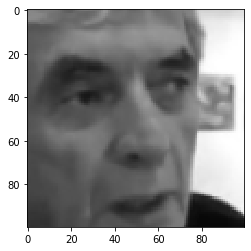

AxesImage(54,36;334.8x217.44)


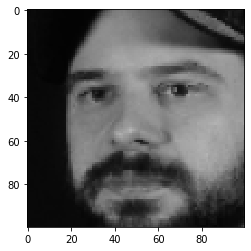

AxesImage(54,36;334.8x217.44)


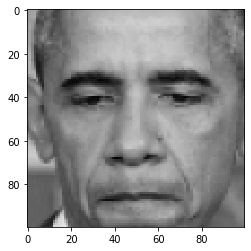

AxesImage(54,36;334.8x217.44)


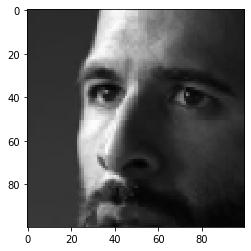

AxesImage(54,36;334.8x217.44)


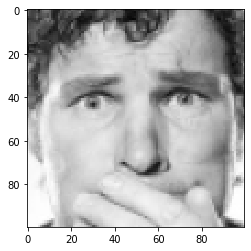

AxesImage(54,36;334.8x217.44)


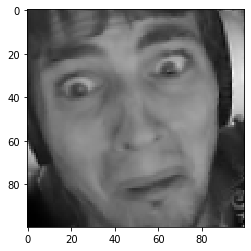

AxesImage(54,36;334.8x217.44)


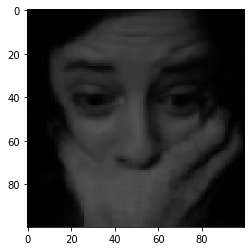

AxesImage(54,36;334.8x217.44)


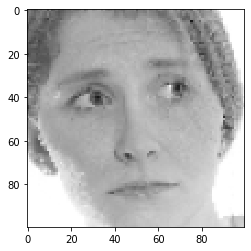

AxesImage(54,36;334.8x217.44)


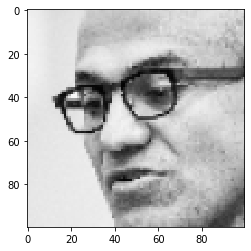

AxesImage(54,36;334.8x217.44)


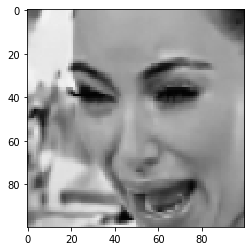

AxesImage(54,36;334.8x217.44)


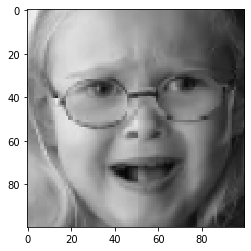

AxesImage(54,36;334.8x217.44)


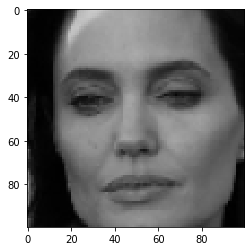

AxesImage(54,36;334.8x217.44)


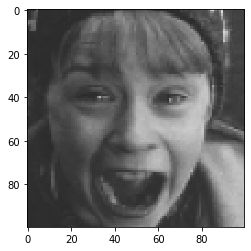

AxesImage(54,36;334.8x217.44)


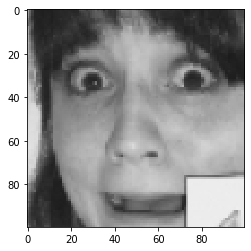

AxesImage(54,36;334.8x217.44)


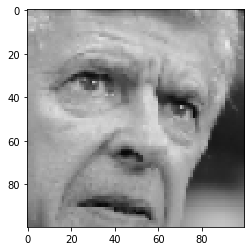

AxesImage(54,36;334.8x217.44)


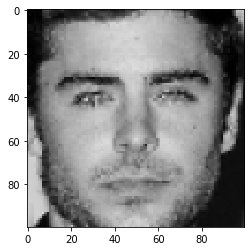

AxesImage(54,36;334.8x217.44)


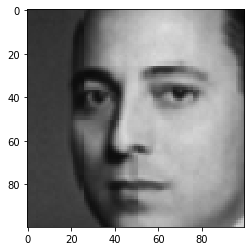

AxesImage(54,36;334.8x217.44)


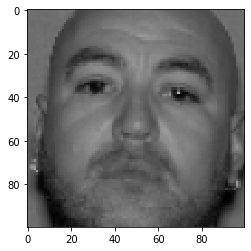

AxesImage(54,36;334.8x217.44)


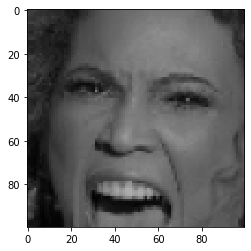

AxesImage(54,36;334.8x217.44)


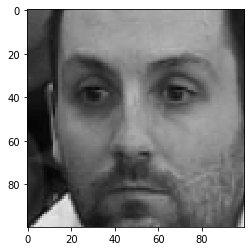

AxesImage(54,36;334.8x217.44)


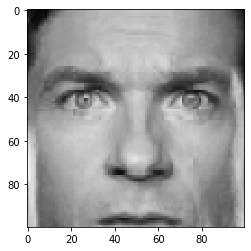

AxesImage(54,36;334.8x217.44)


KeyboardInterrupt: 

In [35]:
for data in test_loader:
    images, labels = data
    images, labels = images.cpu(), labels.cpu()
    for image in images:
        image = image.reshape(100, 100, 3)
        ax = matplotlib.pyplot.gca()
        print(ax.imshow(image))
        matplotlib.pyplot.show()

In [ ]:
tensor([[1.0000e+00, 1.0478e-06],
        [4.7951e-04, 9.9952e-01],
        [8.3892e-05, 9.9992e-01],
        [9.9959e-01, 4.0663e-04],
        [5.2101e-04, 9.9948e-01],
        [1.0000e+00, 3.6816e-07],
        [7.7487e-01, 2.2513e-01],
        [1.0000e+00, 1.0775e-06]], device='cuda:0')

In [164]:
t = torch.randn(8, 2)
t

tensor([[ 0.0860, -0.4960],
        [ 0.3687, -0.0802],
        [-0.7751, -0.9708],
        [ 0.6531, -1.9622],
        [ 0.0340, -0.4656],
        [ 0.9382, -1.4178],
        [-0.0548, -1.9227],
        [ 0.9621,  0.7041]])

In [165]:
t.shape

torch.Size([8, 2])

In [166]:
t[:, 0]

tensor([ 0.0860,  0.3687, -0.7751,  0.6531,  0.0340,  0.9382, -0.0548,  0.9621])

In [123]:

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        sm = torch.nn.Softmax()

        probabilities = sm(outputs) 
        fear_probs = probabilities[:, 0]
        print(fear_probs)


print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


/home/catherine/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


tensor([3.0972e-09, 1.0000e+00, 5.5584e-06, 9.6973e-04, 6.1751e-04, 1.2675e-06,
        6.9858e-09, 9.9997e-01], device='cuda:0')
tensor([2.0703e-06, 6.7370e-07, 5.6648e-01, 2.5369e-05, 1.9870e-12, 1.0000e+00,
        4.4335e-05, 4.9025e-01], device='cuda:0')
tensor([6.9740e-01, 1.0000e+00, 4.2649e-03, 3.4655e-15, 1.0000e+00, 4.2426e-11,
        1.3582e-05, 1.0000e+00], device='cuda:0')
tensor([3.7364e-01, 1.0000e+00, 1.3111e-07, 5.5306e-09, 1.0000e+00, 1.0000e+00,
        4.5480e-06, 1.0000e+00], device='cuda:0')
tensor([1.9838e-09, 4.8269e-10, 9.9432e-01, 2.2905e-03, 9.9099e-03, 1.2573e-07,
        7.7122e-06, 1.0000e+00], device='cuda:0')
tensor([1.0000e+00, 9.9968e-01, 1.2278e-09, 1.0000e+00, 1.6787e-01, 5.3293e-08,
        4.6006e-05, 4.7890e-07], device='cuda:0')
tensor([9.8345e-11, 9.9984e-01, 1.0000e+00, 4.6469e-03, 3.6309e-11, 5.9895e-02,
        8.9399e-01, 1.0512e-01], device='cuda:0')
tensor([2.5732e-08, 1.0000e+00, 1.0000e+00, 9.9064e-01, 9.9999e-01, 1.1598e-01,
        5.

<h2>Prediction on single images</h2>

In [80]:
img = "fear2.jpg"
frame = cv2.imread(img, flags=cv2.IMREAD_COLOR)

cv2.imshow('image',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [139]:
def img_processor(frame_rgb, x, y, w, h):
    im_size = 100
    horizontal_offset = 0 
    vertical_offset = 0 
    extracted_face = frame_rgb[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    extracted_face_r = cv2.resize(extracted_face, (im_size, im_size)) #resize the extracted face
    extracted_face_arr = np.array(extracted_face_r)
    normalized = np.array(extracted_face_arr, np.float32) / 255.
    normalized_arr = np.expand_dims(normalized, axis=0) #only one pic, one sample, so expand dims to turn into 4D array
    face_torch = torch.from_numpy(normalized_arr) #pytorch will only accept torch tensors
    face_torch = face_torch.reshape(1, 3, im_size, im_size) #need to reshape from (1, 100,100, 3) to (1, 3, 100, 100)
    face_torch = face_torch.cuda()
    return face_torch

In [140]:
item = "fear2.jpg"
im_size = 400


image = cv2.imread(item, flags=cv2.IMREAD_COLOR) #open image
face = ia.imresize_single_image(image, (im_size, im_size)) #resize
gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
detected_faces = faceCascade.detectMultiScale(rgb, scaleFactor=1.1, minNeighbors=3, minSize=(50, 50), flags=cv2.CASCADE_SCALE_IMAGE) #detect faces

for face in detected_faces:
    (X, Y, w, h) = face
    if w > 20:
        horizontal_offset = 0
        vertical_offset = 0
        extracted_face = rgb[Y+vertical_offset:Y+h, X+horizontal_offset:X-horizontal_offset+w]
        extracted_face_r = ia.imresize_single_image(extracted_face, (im_size, im_size)) #resize
        
        tester = img_processor(extracted_face_r, X, Y, w, h)
        tester.cuda()
        prediction = prediction(tester.cuda())
    
        print(prediction)

TypeError: 'NoneType' object is not callable

In [63]:
# resize frame for speed.
frame = cv2.resize(frame, (400,200), interpolation=cv2.INTER_CUBIC) #resize #originally INTER_CUBIC
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_rgb = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2RGB)

In [126]:
# Check if gpu support is available
#cuda_avail = torch.cuda.is_available()
#if cuda is available, move the model to the GPU
#if cuda_avail:
    #net.cuda()

def prediction(test_image):
    with torch.no_grad():
        net.cuda()
        output = net(test_image)
        probabilities = sm(outputs) 
        #fear_probs = probabilities[:, 0]
        #print(fear_probs)
        print(probabilities)

In [72]:
haar_face = "haarcascade_frontalface_alt.xml"

faceCascade = cv2.CascadeClassifier(haar_face)

detector = dlib.get_frontal_face_detector() #detects faces

faces = faceCascade.detectMultiScale(frame_rgb, 1.1, scaleFactor=1.1, minNeighbors=3, minSize=(20, 20), flags=cv2.CASCADE_SCALE_IMAGE)

nfaces = 0

for (x,y,w,h) in faces:
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    nfaces = nfaces + 1
        
    extracted_array = img_processor(frame_rgb, x, y, w, h) #apply img_processor func: extracts face and resizes, converts to array
        
    prediction_result = prediction(extracted_array)
    
    prediction_class = prediction_result.argmax(axis=-1)
    
    print(prediction_result)

# show result
cv2.imshow("Result",frame)